In [0]:
# packages needed for Data loading 
import re

import itertools
import urllib
import zipfile
import json
import warnings
from datetime import datetime, timedelta
from multiprocessing import cpu_count

# Data Processing packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from tqdm import tqdm

# Modelling packages 
import xgboost as xgb
#!pip install shap
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Metrics 

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score


pd.options.display.max_columns = None

## Loading Data

Programmatically downloading and loading into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format

In [6]:
# downloading dataset from Github repo
url = "Confidential"
_, _ = urllib.request.urlretrieve(url, filename="transactions.zip")

# checking files in ZIP folder
zf = zipfile.ZipFile('transactions.zip', 'r')
for f in zf.filelist:
    print(f.filename)

transactions.txt


In [7]:
# diplying the files from the zip folder
datafile = zipfile.ZipFile('transactions.zip','r')

for f in datafile.filelist:
    print(f.filename)

transactions.txt


In [8]:
# reading the Transactions.txt data file and loading the data into a pandas data frame

df_t = datafile.open(datafile.filelist[0].filename).read().splitlines()

df = pd.DataFrame(json.loads(line) for line in df_t)

# checking for first 10 rows of data
df.head(10)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.00,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.00,,,,True,,,False,False
5,830329091,830329091,5000.0,5000.00,2016-04-19T16:24:27,30.76,In-N-Out #422833,US,US,02,01,fastfood,01/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.00,,,,True,,,False,False
6,830329091,830329091,5000.0,5000.00,2016-05-21T14:50:35,57.28,Krispy Kreme #685312,US,US,02,01,fastfood,05/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.00,,,,True,,,False,False
7,830329091,830329091,5000.0,5000.00,2016-06-03T00:31:21,9.37,Shake Shack #968081,US,US,05,01,fastfood,01/2021,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.00,,,,True,,,False,False
8,830329091,830329091,5000.0,4990.63,2016-06-10T01:21:46,523.67,Burger King #486122,,US,02,01,fastfood,08/2032,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,9.37,,,,True,,,False,False
9,830329091,830329091,5000.0,5000.00,2016-07-11T10:47:16,164.37,Five Guys #510989,US,US,05,08,fastfood,04/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.00,,,,True,,,False,False


In [9]:
# as we can see straightaway there are empty spaces in the data , replacing them with nan for analysis using Regular expression
df = df.replace(r'^\s*$', np.NaN, regex=True)
df.head(10)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
5,830329091,830329091,5000.0,5000.00,2016-04-19T16:24:27,30.76,In-N-Out #422833,US,US,02,01,fastfood,01/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
6,830329091,830329091,5000.0,5000.00,2016-05-21T14:50:35,57.28,Krispy Kreme #685312,US,US,02,01,fastfood,05/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
7,830329091,830329091,5000.0,5000.00,2016-06-03T00:31:21,9.37,Shake Shack #968081,US,US,05,01,fastfood,01/2021,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
8,830329091,830329091,5000.0,4990.63,2016-06-10T01:21:46,523.67,Burger King #486122,NaN,US,02,01,fastfood,08/2032,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,9.37,NaN,NaN,NaN,True,NaN,NaN,False,False
9,830329091,830329091,5000.0,5000.00,2016-07-11T10:47:16,164.37,Five Guys #510989,US,US,05,08,fastfood,04/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False


#### the structure of the data. Number of records and fields in each record?

In [10]:
df.info()
#priting the total number of rows and features present in the data 
print(f"data set has {df.shape[1]} features and {df.shape[0]} total number of records")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
accountNumber               786363 non-null object
customerId                  786363 non-null object
creditLimit                 786363 non-null float64
availableMoney              786363 non-null float64
transactionDateTime         786363 non-null object
transactionAmount           786363 non-null float64
merchantName                786363 non-null object
acqCountry                  781801 non-null object
merchantCountryCode         785639 non-null object
posEntryMode                782309 non-null object
posConditionCode            785954 non-null object
merchantCategoryCode        786363 non-null object
currentExpDate              786363 non-null object
accountOpenDate             786363 non-null object
dateOfLastAddressChange     786363 non-null object
cardCVV                     786363 non-null object
enteredCVV                  786363 non-null object
cardLast4Digits    

By looking at the basic information of the data itself we can clearly say that the data is mix of categorcial , boolean and numerical data
and also there are 6 features where the count of non null is zero means these features doesn't have any useful informaiton 

out of the total 29 features we have 3 boolean , 10 float64 and 16 categorical columns 

if we apply describe method we will only get numerical data statistics



#### Additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [11]:
# defining a function to iterate summary stats of the different feature columns 

def data_analysis(column_name):
    
    desc = df[column_name].describe()
    total_null = sum(pd.isnull(df[column_name]))
    unique_val = len(df[column_name].unique())
    print(df[column_name].dtype)
    if df[column_name].dtype in ['object','bool']:
        print("Data Analysis for Feature : ", column_name)
        print (f"Total number of records : {desc['count']} \n"
          f"Total number of unique values : {unique_val} \n"
          f"No Maxium value as the dtype is {df[column_name].dtype} \n"
          f"No Minimum value as the dtype is {df[column_name].dtype} \n"
          f"Total number of null values : {total_null} \n")
    else:
        
        print("Data Analysis for Feature : ", column_name)
        print(f"Total number of records : {desc['count']} \n"
          f"Total number of unique values : {unique_val} \n"
          f"Minimum creditLimit is ${desc['min']: .2f}, while maximum creditLimit is ${desc['max']: .2f}. "
            "Also, the 1st quantile, median and 3rd quantile are "
          f"${desc['25%']: .2f}, ${desc['50%']: .2f}, ${desc['75%']: .2f} respectively.\n"
          f"Total number of null values : {total_null} \n")

for col in df.columns:
    data_analysis(col)

ERROR! Session/line number was not unique in database. History logging moved to new session 59
object
Data Analysis for Feature :  accountNumber
Total number of records : 786363 
Total number of unique values : 5000 
No Maxium value as the dtype is object 
No Minimum value as the dtype is object 
Total number of null values : 0 

object
Data Analysis for Feature :  customerId
Total number of records : 786363 
Total number of unique values : 5000 
No Maxium value as the dtype is object 
No Minimum value as the dtype is object 
Total number of null values : 0 

float64
Data Analysis for Feature :  creditLimit
Total number of records : 786363.0 
Total number of unique values : 10 
Minimum creditLimit is $ 250.00, while maximum creditLimit is $ 50000.00. Also, the 1st quantile, median and 3rd quantile are $ 5000.00, $ 7500.00, $ 15000.00 respectively.
Total number of null values : 0 

float64
Data Analysis for Feature :  availableMoney
Total number of records : 786363.0 
Total number of un

As per the summary stats of each of the feature here are the findings :

There are 5000 unique customers based on both account number and customer id

Minimum credit limit is 250 and maxium credit limit is 50000

RecurringAuthInd , posOnPremise, merchantZip, merchantState merchantCity, echoBuffer have no valid values and all the records are NAN , we can safely remove these fields from data set

The Field Merchant name refers to the place the card been swiped or charged at , this field has different suffix followed by merchant name

The Field Acqcountry refres to the country where the card is opened
there are 4 different countries where the card is being operated 






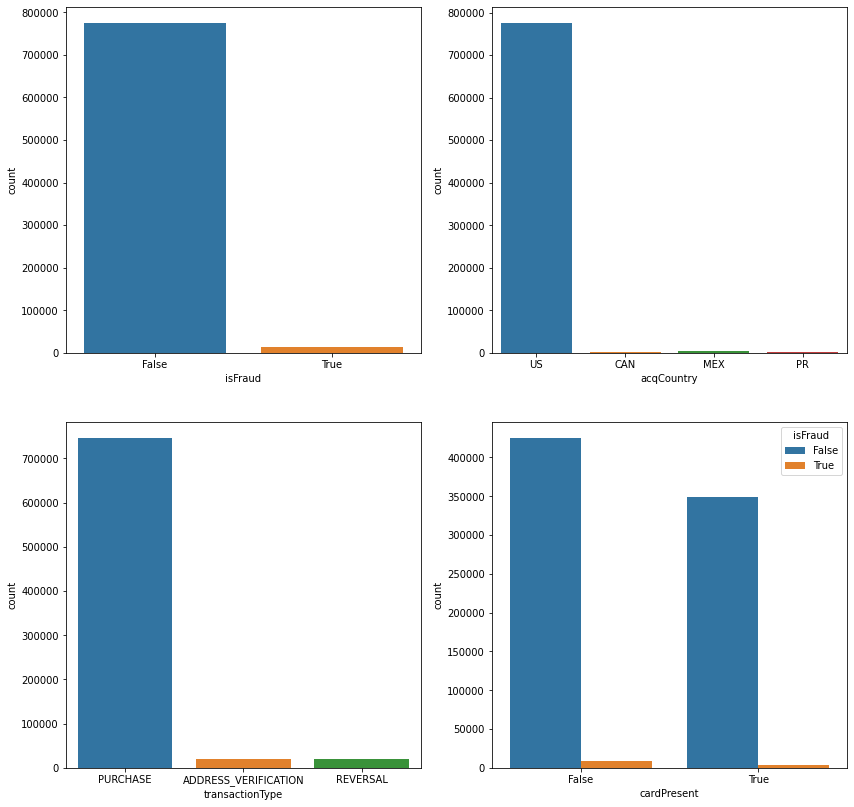

In [18]:
import seaborn as sns
fig,ax = plt.subplots(2,2,figsize=(14,14))

sns.countplot(df['isFraud'],ax=ax[0,0])
sns.countplot(df['acqCountry'],ax=ax[0,1])
sns.countplot(df['transactionType'],ax=ax[1,0])
sns.countplot(df['cardPresent'],hue=df['isFraud'],ax=ax[1,1])


By looking at the graphs most of the cards are issued in US and 
fraud transactions composition is very less in the entire data 
and most of the transactions are related to purchase 

In [19]:
# to find out the count of nulls in the data set across different features
df.apply(lambda x : sum(x.isna()))

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [0]:
# clearly recurringAuthInd posOnPremise merchantZip merchantState merchantCity echoBuffer 
# have NAN as the values in all rows , so we can delete these columns instead of imputation as 
# there's no refrence , this which will help with computation as there features are not needed 

df = df.drop(['echoBuffer',
        'merchantCity',
        'merchantState',
        'merchantZip',
        'posOnPremises',
        'recurringAuthInd'],axis=1)


# data have different type of date fields which are in different formats , below i am bringing all of them into same same format 

df.currentExpDate = pd.to_datetime(df.currentExpDate, errors='coerce', format='%m/%Y').dt.date
df.dateOfLastAddressChange = pd.to_datetime(df.dateOfLastAddressChange, errors='coerce', format='%Y-%m-%d').dt.date
df.accountOpenDate = pd.to_datetime(df.accountOpenDate, errors='coerce', format='%Y-%m-%d').dt.date
df.transactionDateTime = pd.to_datetime(df.transactionDateTime, errors='coerce', format='%Y-%m-%dT%H:%M:%S')

# as mentioned in the analysis merchant name field has suffixes , replacing them using regular expression 
df.merchantName = df.merchantName.map(lambda x: re.sub(r'\s+\#[0-9\-\.\_\s]+', '', x))




## Plot

histogram of the processed amounts of each transaction, the transactionAmount column.

ERROR! Session/line number was not unique in database. History logging moved to new session 60


Text(0, 0.5, 'Frequency')

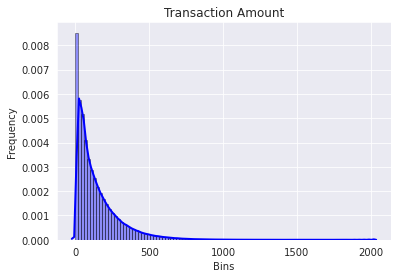

In [28]:
sns.distplot(df['transactionAmount'],hist = True,kde = True,color = 'blue',bins=100
            ,hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':2})

sns.set_style('darkgrid')
plt.title('Transaction Amount')
plt.xlabel('Bins')
plt.ylabel('Frequency')

Very first thing we can notice is distribution is highly right skewed 

there are lot of transactions with 0 amount charged , there could be multiple reasons for that , it could be a cancelled transaction 
or to validate the particular transaction , almost 3 % of the transactions have $0 as the transaction amount 

In [33]:
x = df[df.transactionAmount == 0].shape[0] / df.shape[0] * 100
print("% of the transactions that have $0 amount: ", x)

% of the transactions that have $0 amount:  2.8263028652161912


##### Data Wrangling - Duplicate Transactions

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.


programmatically identifying reversed and multi-swipe transactions

In [0]:
# to work on this module we only need specific number of columns which we can use to find reversed and
# multi transactions , making a copy of the original data frame 

df_1 = df.filter(['accountNumber','merchantName','transactionAmount','transactionType',
          'transactionDateTime','merchantCategoryCode'],axis=1).loc[df['transactionType'] !='ADDRESS_VERIFICATION']


Reversed Transactions code block

In [35]:
# rounding of the transaction amount to two values
df_1.transactionAmount = df_1.transactionAmount.round(2)

# we need to group the data by Account number first and then Merchant name and the transaction amount 
df_g = df_1.groupby(['accountNumber', 'merchantName', 'transactionAmount'])

# creating a logic to get the groups where the transaction type is reversal and the number of rows in that group are even 

df_g = df_g.filter(
    lambda x: ('REVERSAL' in list(x.transactionType))\
        and (x.shape[0] % 2 == 0)
)

# Sorting the values based on account number and Transaction date time 

df_sorted = df_g.sort_values(by=['accountNumber', 'transactionDateTime'])

df_sorted.head(6)

,accountNumber,merchantName,transactionAmount,transactionType,transactionDateTime,merchantCategoryCode
541963,100088067,AMC,22.32,PURCHASE,2016-11-20 07:57:05,entertainment
541964,100088067,AMC,22.32,REVERSAL,2016-11-20 08:00:04,entertainment
87919,100328049,Lyft,43.74,PURCHASE,2016-01-15 20:34:35,rideshare
87920,100328049,Lyft,43.74,REVERSAL,2016-01-15 20:36:18,rideshare
87935,100328049,McDonalds,284.97,PURCHASE,2016-03-24 22:57:15,fastfood
87936,100328049,McDonalds,284.97,REVERSAL,2016-03-26 17:35:09,fastfood


Multiple Transaction identification code block 

In [36]:

# Grouping dataset by accountNumber, merchantName, transactionAmount and transaction DATE
df_g1 = df_1.groupby(['accountNumber', 'merchantName', 'transactionAmount', df_1.transactionDateTime.dt.date])

# Creating a logic to get the groups where the transaction type is Purchase and the number of rows in that group are odd 
# for the same transaction amount on the same transaction date 
df_g1 = df_g1.filter(lambda x: (set(x.transactionType) == {'PURCHASE'}) and (x.shape[0] > 1))
df_m = df_g1.sort_values(by=['accountNumber', 'transactionDateTime'])
df_m.head(10)


,accountNumber,merchantName,transactionAmount,transactionType,transactionDateTime,merchantCategoryCode
541955,100088067,Fresh Flowers,411.35,PURCHASE,2016-10-16 18:01:00,online_gifts
541956,100088067,Fresh Flowers,411.35,PURCHASE,2016-10-16 18:01:02,online_gifts
151426,100737756,Franks Deli,693.50,PURCHASE,2016-01-18 01:55:24,food
151427,100737756,Franks Deli,693.50,PURCHASE,2016-01-18 01:55:28,food
151428,100737756,Franks Deli,693.50,PURCHASE,2016-01-18 01:58:26,food
151512,100737756,South Steakhouse,211.22,PURCHASE,2016-07-02 12:05:04,food
151513,100737756,South Steakhouse,211.22,PURCHASE,2016-07-02 12:07:00,food
151517,100737756,34th BBQ,43.25,PURCHASE,2016-07-10 14:31:07,food
151518,100737756,34th BBQ,43.25,PURCHASE,2016-07-10 14:32:06,food
220071,101132326,Regal Cinemas,188.86,PURCHASE,2016-08-24 02:09:08,entertainment


#### total number of transactions and total dollar amount do you estimate for the reversed transactions For the multi-swipe transactions

In [37]:
# total number of reversed transactions and dollar amount

rv_count = df_sorted.shape[0]/2
rv_total = df_sorted.transactionAmount.sum()/2

print("Total Number of records that have reversed transactions : ", rv_count)
print("Total Amount of reversed transactions for duplciated : ", rv_total)

Total Number of records that have reversed transactions :  17521.0
Total Amount of reversed transactions for duplciated :  2631633.6


In [38]:
# calculating the total number of multi transactions and dollar amount 

df_g1 = df_m.groupby(['accountNumber', 'merchantName', 'transactionAmount', df_m.transactionDateTime.dt.date])

# deleting one of the transaction as that will be normal / original transaction
df_new = df_g1.size() - 1
# resetting the index 
df_sum = df_new.reset_index()
print(df_sum)

# calculating the sum of multiple transactions 

df_sum = df_sum.transactionAmount * df_sum[0]

dup_count = int(df_new.sum())
dup_total = df_sum.sum()

print("Total Number of records that have multiple transactions : ", dup_count)
print("Total Amount for multiple swipes of transactions : ", dup_total)


     accountNumber      merchantName  transactionAmount transactionDateTime  0
0        100088067     Fresh Flowers             411.35          2016-10-16  1
1        100737756          34th BBQ              43.25          2016-07-10  1
2        100737756       Franks Deli             693.50          2016-01-18  2
3        100737756  South Steakhouse             211.22          2016-07-02  1
4        101132326     Regal Cinemas             188.86          2016-08-24  1
...            ...               ...                ...                 ... ..
6683     999086814         apple.com              22.76          2016-12-19  1
6684     999086814         sears.com             178.57          2016-01-23  1
6685     999086814       staples.com             172.50          2016-08-04  1
6686     999257059  Wall Street News              47.58          2016-01-14  1
6687     999283629    Delta Airlines             247.40          2016-04-09  1

[6688 rows x 5 columns]
Total Number of records tha

#### Question 3.3

Did you find anything interesting about either kind of transaction?

#### Time Intervals

In [45]:
def time_interval(k):
    k = sorted(k)
    return [np.abs(k[i] - k[i-1]) for i, _ in enumerate(k[1:])]

df_g = (
    df_sorted
    .groupby(['accountNumber', 'merchantName', 'transactionAmount'])['transactionDateTime', 'merchantCategoryCode']
    .agg(list)
    .reset_index()
)
df_g['timeIntervals'] = df_g.transactionDateTime.map(time_interval)
df_g.head()

,accountNumber,merchantName,transactionAmount,transactionDateTime,merchantCategoryCode,timeIntervals
0,100088067,AMC,22.32,"[2016-11-20 07:57:05, 2016-11-20 08:00:04]","[entertainment, entertainment]",[0 days 00:02:59]
1,100328049,Lyft,43.74,"[2016-01-15 20:34:35, 2016-01-15 20:36:18]","[rideshare, rideshare]",[0 days 00:01:43]
2,100328049,McDonalds,284.97,"[2016-03-24 22:57:15, 2016-03-26 17:35:09]","[fastfood, fastfood]",[1 days 18:37:54]
3,100737756,34th BBQ,93.67,"[2016-05-30 00:42:32, 2016-06-06 22:56:52]","[food, food]",[7 days 22:14:20]
4,100737756,Best Bistro,501.29,"[2016-08-11 09:20:41, 2016-08-24 20:21:19]","[food, food]",[13 days 11:00:38]


Text(0, 0.5, 'Frequency')

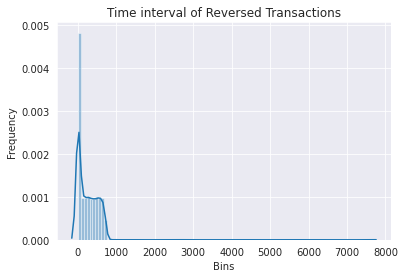

In [49]:
rev_intervals = [i.total_seconds() / 3600 for i in itertools.chain(*list(df_g.timeIntervals))]

sns.distplot(np.array(rev_intervals),hist=True,bins=100)

plt.title('Time interval of Reversed Transactions')
plt.xlabel('Bins')
plt.ylabel('Frequency')

Based on the Histogram , most of the time intervals for reversed transactions are happened on the same day but there are few reversals that happened after a month as well , Below we can find those Transactions 

In [50]:
# Transactions that are reversed after at least a month time gap from the transaction 

df_g[df_g.timeIntervals.map(lambda x: x[0].total_seconds() / 3600) > (24 * 31)].head()

,accountNumber,merchantName,transactionAmount,transactionDateTime,merchantCategoryCode,timeIntervals
872,151580474,AMC,4.21,"[2016-09-14 20:33:31, 2016-11-03 16:53:33]","[entertainment, entertainment]",[49 days 20:20:02]
1416,187912273,AMC,2.78,"[2016-01-25 18:16:26, 2016-04-19 17:27:51]","[entertainment, entertainment]",[84 days 23:11:25]
1910,208319653,apple.com,15.01,"[2016-06-08 10:38:00, 2016-12-29 19:10:32]","[online_retail, online_retail]",[204 days 08:32:32]
1949,208319653,sears.com,0.00,"[2016-06-28 18:09:44, 2016-11-27 14:24:16]","[online_retail, online_retail]",[151 days 20:14:32]
2418,236923795,AMC,0.00,"[2016-04-03 12:21:48, 2016-06-26 09:20:42]","[entertainment, entertainment]",[83 days 20:58:54]


Some of these transactions are related to Entertainment which is mainly AMC monthly card and online shopping related 

Text(0, 0.5, 'Frequency')

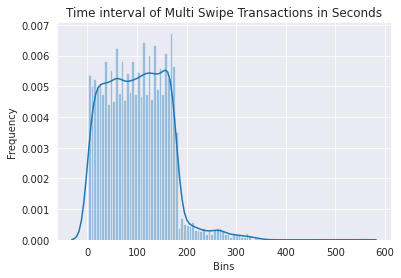

In [59]:
# Multiple swipe Transaction time intervals 
df_g = (
    df_m
    .groupby(['accountNumber', 'merchantName', 'transactionAmount'])['transactionDateTime']
    .agg(list)
    .reset_index()
)
df_g['timeIntervals'] = df_g.transactionDateTime.map(time_interval)

multi_intervals = [i.total_seconds() for i in itertools.chain(*list(df_g.timeIntervals))]

multi_intervals = np.array(multi_intervals)

sns.distplot(multi_intervals[multi_intervals < 3600],hist=True,bins=100,kde=True)

plt.title('Time interval of Multi Swipe Transactions in Seconds')
plt.xlabel('Bins')
plt.ylabel('Frequency')

From the first look of the Historgram almost all of the Multi swipes are on the same day 

In [55]:
# Time interval between Transactions that are multi swipe 

df_g[df_g.timeIntervals.map(lambda x: x[0].total_seconds()) > 3600].head()

#by looking at the first few records these transactions where lag is more are also related to online transactions 

,accountNumber,merchantName,transactionAmount,transactionDateTime,timeIntervals
1239,273053513,cheapfast.com,317.91,"[2016-05-08 16:02:31, 2016-05-08 18:33:56]",[0 days 02:31:25]
1919,369308035,cheapfast.com,14.28,"[2016-07-23 21:01:30, 2016-07-23 23:10:51]",[0 days 02:09:21]
2091,380680241,Blue Mountain Online Services,1.48,"[2016-02-04 13:55:39, 2016-02-04 23:33:00]",[0 days 09:37:21]
2107,380680241,Blue Mountain Online Services,78.81,"[2016-04-12 15:30:35, 2016-04-12 21:49:38]",[0 days 06:19:03]
2126,380680241,Blue Mountain Online Services,234.80,"[2016-10-27 02:36:38, 2016-10-27 20:41:21]",[0 days 18:04:43]


## Model

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.



In [60]:
df.apply(lambda x : sum(x.isna()))

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

In [0]:
# Preparing the data for Modelling 

df_model = df.copy(deep=True)
# Dropping the unusable fields that are ID like which doesn't provide too many insights into modelling 
df_model = df_model.drop(
    [
        'accountNumber',
        'customerId',
        'cardLast4Digits'],
    axis=1
)
df_model.head()

# transaction type , posConditionCode ,  acqCountry, merchantCountryCode all have the missing values
# we can either drop them or impute them , Dropping them will means loosing the data 
# i will impute with most frequent values in the respective columns based on their value_counts 

df_model.acqCountry = df_model.acqCountry.fillna('US')

df_model.merchantCountryCode = df_model.merchantCountryCode.fillna('US')

df_model.posConditionCode = df_model.posConditionCode.fillna('01')

df_model.transactionType = df_model.transactionType.fillna('PURCHASE')

# Pos Entry code doesn't have any one category which has most of the record belog to , instead of dropping i am creating a new code 08 
# as Pos entry code 

df_model.posEntryMode = df_model.posEntryMode.fillna('08')

In [0]:
# Adding new fields based on the data fields as the date fields aren't that useful for modelling 

#Adding the Account age based on transaction date and account open date 
df_model['accountAge'] = ((df_model.transactionDateTime.dt.date - df_model.accountOpenDate) / np.timedelta64(1, 'D')).astype(int)

# Adding the Expirein days by using current Expiry data and transaction date 
df_model['expireIn'] = ((df_model.currentExpDate - df_model.transactionDateTime.dt.date) / np.timedelta64(1, 'D')).astype(int)

# Adding the Last Adress change age based on Transaction date and last date of adress change
df_model['lastAddressChangeAge'] = ((df_model.transactionDateTime.dt.date - df_model.dateOfLastAddressChange) / np.timedelta64(1, 'D')).astype(int)

#Dropping the Date fields 
df_model = df_model.drop(['transactionDateTime', 'accountOpenDate', 'currentExpDate', 'dateOfLastAddressChange'], axis=1)

0.9927246584559688

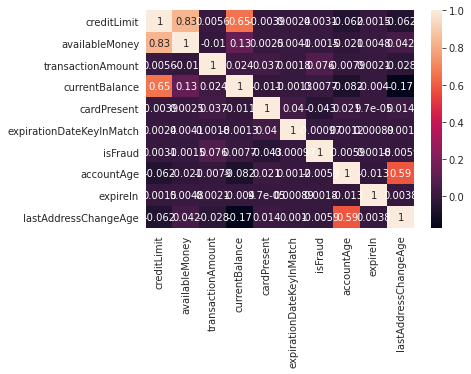

In [65]:
#Ref : https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix

# calcualting the correlation between categorical features and numerical features 

corr = df_model.corr()
sns.heatmap(corr,annot=True)

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramers_v(df_model.acqCountry.astype('category'),df_model.merchantCountryCode.astype('category'))

From the Above analysis both categorical columns acqCountry and merchantCountryCode are highly related and we can delete one of them from the data 

And also Current balance and Available money are highly correlated with Credit limit 

In [66]:
df_model.head()

,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,accountAge,expireIn,lastAddressChangeAge
0,5000.0,5000.0,98.55,Uber,US,US,02,01,rideshare,414,414,PURCHASE,0.0,False,False,False,518,2483,518
1,5000.0,5000.0,74.51,AMC,US,US,09,01,entertainment,486,486,PURCHASE,0.0,True,False,False,577,2669,577
2,5000.0,5000.0,7.47,Play Store,US,US,09,01,mobileapps,486,486,PURCHASE,0.0,False,False,False,605,3188,605
3,5000.0,5000.0,7.47,Play Store,US,US,09,01,mobileapps,486,486,PURCHASE,0.0,False,False,False,637,3156,637
4,5000.0,5000.0,71.18,Tim Hortons,US,US,02,01,fastfood,885,885,PURCHASE,0.0,True,False,False,231,4939,231


Creating a New column to CVV correct based on card cvv and entered cvv 
Dropping Acq country as it's correlated with merchantCountryCode , keeping merchantCountryCode because it's closer to transaction data

In [0]:
df_model['isCVVCorrect'] = (df_model.cardCVV == df_model.enteredCVV).astype(int)

df_model = df_model.drop(['availableMoney','currentBalance','acqCountry','merchantName','cardCVV','enteredCVV'], axis=1)

# Converting boolean feature columns into numerical 
df_model.cardPresent = df_model.cardPresent.astype(int)
df_model.expirationDateKeyInMatch = df_model.expirationDateKeyInMatch.astype(int)
df_model.isFraud = df_model.isFraud.astype(int)

In [14]:
# converting the categorcial columns into Numerical using get dummies method 
df_model = pd.get_dummies(df_model)

print(df_model.shape)
df_model.head(10)

(786363, 44)


,creditLimit,transactionAmount,cardPresent,expirationDateKeyInMatch,isFraud,accountAge,expireIn,lastAddressChangeAge,isCVVCorrect,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,posEntryMode_02,posEntryMode_05,posEntryMode_08,posEntryMode_09,posEntryMode_80,posEntryMode_90,posConditionCode_01,posConditionCode_08,posConditionCode_99,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,5000.0,98.55,0,0,0,518,2483,518,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,5000.0,74.51,1,0,0,577,2669,577,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5000.0,7.47,0,0,0,605,3188,605,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,5000.0,7.47,0,0,0,637,3156,637,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,5000.0,71.18,1,0,0,231,4939,231,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,5000.0,30.76,1,0,0,257,1352,257,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,5000.0,57.28,1,0,0,289,1441,289,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,5000.0,9.37,1,0,0,302,1673,302,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,5000.0,523.67,1,0,0,309,5896,309,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,5000.0,164.37,1,0,0,340,1360,340,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Splitting the data into Train / Test / Validation 

In [0]:
# Creating the Training and Testing and validation data sets 


y = df_model['isFraud']
X = df_model.drop('isFraud',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 1)

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state = 1)

# normalizing the data using Standard Scalar 

sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_val_std = sc.fit_transform(X_val)
X_test_std = sc.fit_transform(X_test)

In [16]:
X_train_std.shape

(503272, 43)

Training a Simple Model without any Hyper parameter tuning as Base Model

and One thing to keep in mind is out class is is Fraud Detection and this data set is Highly imbalanced as the most of the data is not fraud 

In [17]:
clf_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train_std, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [18]:
# Predicting the Output based on base model 
y_pred = clf_pruned.predict(X_test_std)
print("Trianing set score :", clf_pruned.score(X_train_std, y_train))
print("Testing set score :", clf_pruned.score(X_test_std , y_test))

print("Confusion Matrix:", confusion_matrix(y_test, y_pred))

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall Score: ",recall_score(y_test, y_pred,average="binary"))

Trianing set score : 0.9842073471204438
Testing set score : 0.9846318185575401
Confusion Matrix: [[154856      0]
 [  2417      0]]
Accuracy:  0.9846318185575401
Recall Score:  0.0


Building the models based on Hyperparameter Tunin
# 1.Random Forest

In [64]:
# RandomForest:

param_test = {
    'n_estimators': [100, 300, 500,800], # Number of trees in random forest
    'max_depth': [5, 8, 15, 25], # max number of depth in weak tree learner
    'min_samples_split': [2, 5, 10,15], # min number of samples required to split a node
    'min_samples_leaf': [1, 2, 5,10], # min number of samples required at each leaf node
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=10),
    param_distributions=param_test,
    n_iter=50,
    cv=3, # 3 fold cross validation
    scoring='roc_auc', # AUROC as evaulation
    n_jobs=cpu_count() - 1, 
    verbose=10
)
random_search.fit(X_val_std, y_val)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=10, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=10, max_depth=5, score=0.752, total=  20.2s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=10, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s remaining:    0.0s


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=10, max_depth=5, score=0.727, total=  14.4s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=10, max_depth=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.6s remaining:    0.0s


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=10, max_depth=5, score=0.742, total=  14.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=15 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.9s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=15, score=0.753, total=  10.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=15 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   59.2s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=15, score=0.741, total=  10.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=15 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_depth=15, score=0.751, total=  10.2s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_depth=8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_depth=8, score=0.761, total=  34.3s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_depth=8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.9min remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_depth=8, score=0.735, total=  33.8s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_depth=8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_depth=8, score=0.752, total=  33.7s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=2, max_depth=15 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.0min remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=2, max_depth=15, score=0.754, total=  10.0s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=2, max_depth=15 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=2, max_depth=15, score=0.742, total=  10.2s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=2, max_depth=15 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=2, max_depth=15, score=0.755, total=  10.1s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=25 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=25, score=0.729, total= 1.0min
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=25 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=25, score=0.727, total= 1.0min
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=25 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 96.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
# defining the function to find the best parameters 

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')


In [66]:
# displaying the best parameters 
display(random_search)

Best parameters are: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 15}


0.74 + or -0.01 for the {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 5}
0.749 + or -0.005 for the {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 15}
0.749 + or -0.011 for the {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 8}
0.75 + or -0.006 for the {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 15}
0.729 + or -0.001 for the {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 25}
0.714 + or -0.004 for the {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 25}
0.742 + or -0.002 for the {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 25}
0.752 + or -0.005 for the {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth':

# Re Training the Random Forest Model With Best Parameters

In [0]:
# Setting up the hyper parameters based on the best parameters 
clf_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    max_features='auto',
    min_samples_split=5,
    min_samples_leaf=10,
    bootstrap=False,
    n_jobs=-1 # using all CPU cores
).fit(X_train_std, y_train)

In [69]:
# Random Forest Model Prediction on Test set 
y_prob_rf = clf_rf.predict_proba(X_test_std)[:, 1]
y_pred_rf= clf_rf.predict(X_test_std)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154856
           1       0.00      0.00      0.00      2417

    accuracy                           0.98    157273
   macro avg       0.49      0.50      0.50    157273
weighted avg       0.97      0.98      0.98    157273



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# 2.XG boost model

In [49]:
# Setting up the XG boost Classifier
parameters = {
    "n_estimators":[50,250],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.02,0.05,0.2],
    'gamma':[0.1,0.2,0.3]
}
param = {
    "n_jobs": 10,
    "grow_policy": "lossguide",
    "tree_method": "hist", # fast histogram algorithm
    "max_bin": 512,
}

random_search1 = RandomizedSearchCV(
    xgb.XGBClassifier(**param),
    param_distributions=parameters,
    n_iter=100,
    cv=3, # 3 fold cv
    scoring='roc_auc', # AUROC as evaulation
    n_jobs=cpu_count() - 1, 
    verbose=10
)
random_search1.fit(X_val, y_val)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=50, max_depth=3, learning_rate=0.2, gamma=0.3 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, max_depth=3, learning_rate=0.2, gamma=0.3, score=0.755, total=   1.6s
[CV] n_estimators=50, max_depth=3, learning_rate=0.2, gamma=0.3 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=50, max_depth=3, learning_rate=0.2, gamma=0.3, score=0.744, total=   1.5s
[CV] n_estimators=50, max_depth=3, learning_rate=0.2, gamma=0.3 ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  n_estimators=50, max_depth=3, learning_rate=0.2, gamma=0.3, score=0.759, total=   1.5s
[CV] n_estimators=250, max_depth=1, learning_rate=0.2, gamma=0.3 .....


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s


[CV]  n_estimators=250, max_depth=1, learning_rate=0.2, gamma=0.3, score=0.757, total=   3.8s
[CV] n_estimators=250, max_depth=1, learning_rate=0.2, gamma=0.3 .....


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.3s remaining:    0.0s


[CV]  n_estimators=250, max_depth=1, learning_rate=0.2, gamma=0.3, score=0.744, total=   3.8s
[CV] n_estimators=250, max_depth=1, learning_rate=0.2, gamma=0.3 .....


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.1s remaining:    0.0s


[CV]  n_estimators=250, max_depth=1, learning_rate=0.2, gamma=0.3, score=0.756, total=   3.7s
[CV] n_estimators=50, max_depth=3, learning_rate=0.01, gamma=0.3 .....


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.8s remaining:    0.0s


[CV]  n_estimators=50, max_depth=3, learning_rate=0.01, gamma=0.3, score=0.684, total=   1.5s
[CV] n_estimators=50, max_depth=3, learning_rate=0.01, gamma=0.3 .....


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.3s remaining:    0.0s


[CV]  n_estimators=50, max_depth=3, learning_rate=0.01, gamma=0.3, score=0.713, total=   1.5s
[CV] n_estimators=50, max_depth=3, learning_rate=0.01, gamma=0.3 .....


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   18.8s remaining:    0.0s


[CV]  n_estimators=50, max_depth=3, learning_rate=0.01, gamma=0.3, score=0.707, total=   1.5s
[CV] n_estimators=50, max_depth=1, learning_rate=0.2, gamma=0.1 ......


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   20.3s remaining:    0.0s


[CV]  n_estimators=50, max_depth=1, learning_rate=0.2, gamma=0.1, score=0.735, total=   1.1s
[CV] n_estimators=50, max_depth=1, learning_rate=0.2, gamma=0.1 ......
[CV]  n_estimators=50, max_depth=1, learning_rate=0.2, gamma=0.1, score=0.727, total=   1.1s
[CV] n_estimators=50, max_depth=1, learning_rate=0.2, gamma=0.1 ......
[CV]  n_estimators=50, max_depth=1, learning_rate=0.2, gamma=0.1, score=0.740, total=   1.1s
[CV] n_estimators=250, max_depth=5, learning_rate=0.02, gamma=0.3 ....
[CV]  n_estimators=250, max_depth=5, learning_rate=0.02, gamma=0.3, score=0.745, total=  10.9s
[CV] n_estimators=250, max_depth=5, learning_rate=0.02, gamma=0.3 ....
[CV]  n_estimators=250, max_depth=5, learning_rate=0.02, gamma=0.3, score=0.735, total=  11.6s
[CV] n_estimators=250, max_depth=5, learning_rate=0.02, gamma=0.3 ....
[CV]  n_estimators=250, max_depth=5, learning_rate=0.02, gamma=0.3, score=0.747, total=  11.7s
[CV] n_estimators=250, max_depth=5, learning_rate=0.05, gamma=0.2 ....
[CV]  n_es

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 37.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           grow_policy='lossguide',
                                           learning_rate=0.1, max_bin=512,
                                           max_delta_step=0, max_depth=3,
                                           min_child_weight=1, missing=None,
                                           n_estimators=100, n_jobs=10,
                                           nthread=None,
                                           objective='binary:logistic',
                                           rando...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, sile

In [54]:
# Displaying the best hyper parameters 
display(random_search1)

Best parameters are: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1}


0.753 + or -0.006 for the {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3}
0.752 + or -0.006 for the {'n_estimators': 250, 'max_depth': 1, 'learning_rate': 0.2, 'gamma': 0.3}
0.701 + or -0.013 for the {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}
0.734 + or -0.005 for the {'n_estimators': 50, 'max_depth': 1, 'learning_rate': 0.2, 'gamma': 0.1}
0.742 + or -0.005 for the {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0.3}
0.762 + or -0.006 for the {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2}
0.732 + or -0.003 for the {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2}
0.733 + or -0.003 for the {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3}
0.715 + or -0.006 for the {'n_estimators': 250, 'max_depth': 1, 'learning_rate': 0.02, 'gamma': 0.2}
0

# Retraining the XG boost model with best Hyper parameters 

In [58]:
param = {
    "learning_rate": 0.2, # set low eta
    "n_estimators": 250, # number of trees under early stopping 
    "max_depth": 3, # max depth of each tree learner
    "min_child_weight": 1, 
    "gamma": 0.1, # regularization param
    "objective": "binary:logistic", # binary classification
    "max_delta_step": 1, # set this to one since the target is highly unbalanced
    "n_jobs": 10,
    "tree_method": "hist",
    "max_bin": 512, 
    "grow_policy": "lossguide"
}

clf_xgb = xgb.XGBClassifier(**param).fit(
    X_train_std,
    y_train,
    eval_set=[(X_train_std, y_train), (X_val_std, y_val)],
    eval_metric=["logloss", "auc"],
    early_stopping_rounds=200,
    verbose=True,
)

[0]	validation_0-logloss:0.600956	validation_0-auc:0.5	validation_1-logloss:0.601407	validation_1-auc:0.5
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.519491	validation_0-auc:0.5	validation_1-logloss:0.519584	validation_1-auc:0.5
[2]	validation_0-logloss:0.446972	validation_0-auc:0.5	validation_1-logloss:0.447286	validation_1-auc:0.5
[3]	validation_0-logloss:0.383728	validation_0-auc:0.5	validation_1-logloss:0.384141	validation_1-auc:0.5
[4]	validation_0-logloss:0.329199	validation_0-auc:0.5	validation_1-logloss:0.329548	validation_1-auc:0.5
[5]	validation_0-logloss:0.282354	validation_0-auc:0.5	validation_1-logloss:0.282822	validation_1-auc:0.5
[6]	validation_0-logloss:0.242577	validation_0-auc:0.510996	validation_1-logloss:0.243303	validation_1-auc:0.508102
[7]	validation_0-logloss:0.2092	validation_0-auc:0.516124	validation_1-logloss:0.210056	va

In [60]:
# Prediction on the Test set on using XG boost model
y_prob_xgb = clf_xgb.predict_proba(X_test_std)[:, 1]
y_pred_xgb = clf_xgb.predict(X_test_std)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154856
           1       0.00      0.00      0.00      2417

    accuracy                           0.98    157273
   macro avg       0.49      0.50      0.50    157273
weighted avg       0.97      0.98      0.98    157273



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


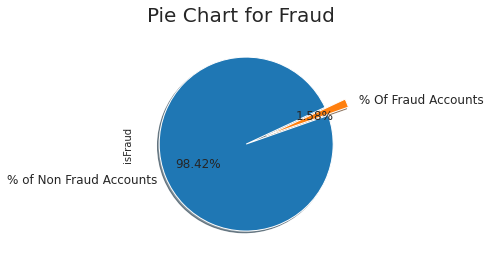

In [96]:
# Pie chat to show the % of Fraud and non fraud transactions in the data set

labels ="% of Non Fraud Accounts", " % Of Fraud Accounts"

plt.suptitle('Pie Chart for Fraud', fontsize=20)

df_model["isFraud"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', shadow=True,
                                             labels=labels, fontsize=12, startangle=25)

#### An estimate of performance using an appropriate sample

XG Boost Classifier Score:  0.7896798122954605
Random  Forest Classifier Score:  0.7876258227136916


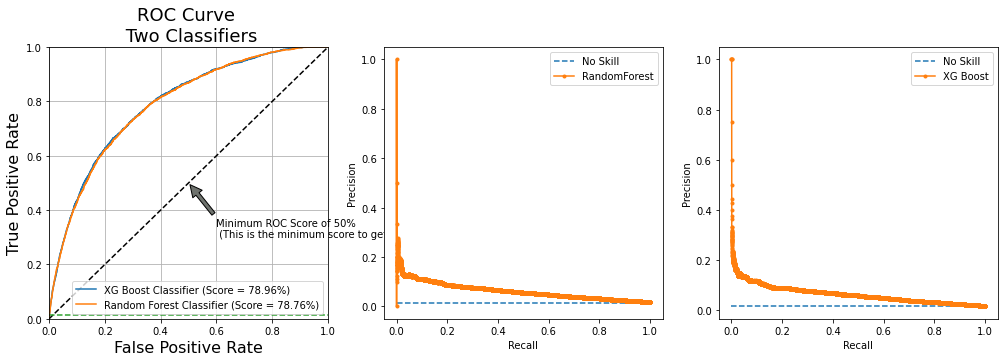

In [80]:
def graph_roc_curve_multiple(y_test,y_prob_xgb,y_prob_rf):

    xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test, y_prob_xgb)
    rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, y_prob_rf)

    print('XG Boost Classifier Score: ', roc_auc_score(y_test, y_prob_xgb))
    print('Random  Forest Classifier Score: ', roc_auc_score(y_test, y_prob_rf))

    plt.figure(figsize=(17,5))
    plt.subplot(131)
    plt.title('ROC Curve \n Two Classifiers', fontsize=18)
    plt.plot(xgb_fpr, xgb_tpr, label='XG Boost Classifier (Score = 78.96%)')
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (Score = 78.76%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])

    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    plt.grid(True)
#plot the no skill precision-recall curve
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
#plot model precision-recall curve
    plt.subplot(132)
    precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='RandomForest')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
#plot model precision-recall curve
    plt.subplot(133)
    precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='XG Boost')

# X and Y axis labels 
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()	  
    
graph_roc_curve_multiple(y_test,y_prob_xgb,y_prob_rf)
plt.show()

In [76]:
y_test.value_counts()

0    154856
1      2417
Name: isFraud, dtype: int64

In [0]:
y_pred_xgb_1 = y_pred_xgb.tolist()

In [101]:
y_pred_xgb_1.count(0)

157273

- **Precision / Recall**:

One of the Very first thing to notice is the data is highly imbalanced hence the evalutaion of the model becomes crucial 

Is Fraud False has been changed to 0 and True as 1 , based on the model training all the cases where 0 is present is considered as Positives and 1 as negatives by model 

by looking at the Test set class label we have 2417 Negative samples and 154856 labels as the positive 

which means Actual True positive are 154856 and Actual True negatvie are 2417 model has predicted that all the 157273 as positive based on the precision and recall metrics 

precision is defined as True positive / T.P + F. P 

in this scenarios T.P = 154856 and Model Predicted T.P as 157273 which means F.P are 2417 and precision comes to about 98 % 

similary Recall is defined as True positive / T.P + False negative it's also called as True positive rate 

false negative becomes crucial here but in our scenario model has predicted Zero false negatives because of that Recall is coming to 1 which is not correct as the model labelling some of the negatives as positives , hence these two metrics are not the right metrics to evaluate when the positive class labels as high 

to evarualte this we turn to AUC and ROC where False positive rate is involved 

- **AUC ROC (Receiver Operating Characteristic) Curve**: 

This curve is used to define model's ability to seperate fraud and non fraud transactions , a Model with perfect prediction will have AUC of 1 while curve being closer to upper left corner , the model is able to achieve higher true positives with low false positives , this curve will not be useful when the data is balanced as the curve will be more diagonal 

in this scenario false positive rate is defined as 
False positive /False positive + True negative which comes down to 

2417 / 2417 + 2417 = 0.5 , and the Area that is covered comes to 78 % at 0.5 


The reason to choose RandomForest and Xg Boost model is both of them are industry recommended and have been producting great results in predicting Fraud in different sectors 

and the Execution speed and model performance are other two main reasons

Refrence : https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

There are many way to evaluate the Tree based models like Gini , feature importance , SHAP , i will be leveragign the Shap as it's a great way to represent feature importance visually 

In [104]:
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


ERROR! Session/line number was not unique in database. History logging moved to new session 65


ERROR! Session/line number was not unique in database. History logging moved to new session 66


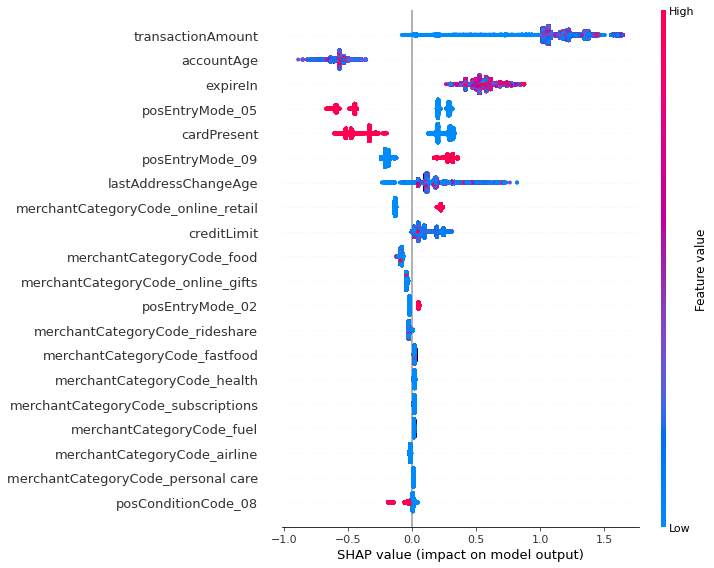

In [105]:
shap.summary_plot(shap_values, X_test)

Each row is one feature, x-axis is the SHAP value. Each dot is one instance, red means the value of feature is large and blue mean small.

posEntryMode_05, cardPresent, posEntryMode_09 , transactionamount are important features: they are basically negatively related to fraud transation. 

card present becomes really important as the most of the online transactions are without cards 

transactionAmount, creditLimit, Expire in and lastAddressChangeAge are important features as well: we can interprete them as, the higher the values the more possible the transaction is fraud.

#### Questions:
- Some of the Fields in data Dictionary are not clear from their column name , it would be great if i can understand more on what these features are and how they are related to fraud 
- do we have a anything that is in place for fraud detection currently which we can evaulate against?

#### Things to Focus on with more time:
- Very first thing is Solving the Class Imbalance Problem , SMOTE (Synthetic minority over sampling) is the best method , it's been a revelation in over sampling 
- More Feature Engineering 
- Feature Selection using LASSO or RIDGE 
- Leverage the exising Neural Nets as the indurstry is driving towards NN , i have done a simple over view of the NN below 

- Re train the models by flipping the Positive and negative class by changing the 1 as positive class and 0 as negative class , in this scenario positive class becomes minor and Recal can be used as Metric

In [106]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
# Initialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 43))
# Adding the second hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 300, epochs = 10)

y_pred_nn = classifier.predict(X_test_std)
y_pred_nn = (y_pred > 0.5)
score = classifier.evaluate(X_test_std, y_test)
score

print(classification_report(y_test, y_pred_nn))

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





503272/503272 [==============================] - 3s 7us/step - loss: 0.0987 - acc: 0.9827
Epoch 2/10
503272/503272 [==============================] - 3s 6us/step - loss: 0.0890 - acc: 0.9842
Epoch 3/10
503272/503272 [==============================] - 3s 6us/step - loss: 0.0835 - acc: 0.9842
Epoch 4/10
503272/503272 [==============================] - 3s 6us/step - loss: 0.0800 - acc: 0.9842
Epoch 5/10
503272/503272 [==============================] - 3s 6us/step - loss: 0.0792 - acc: 0.9842
Epoch 6/10
503272/503272 [==============================] - 3s 6us/step - loss: 0.0793 - acc: 0.9842
Epoch 7/10
503272/503272 [==============================] - 3s 6us/step - loss: 0.0793 - acc: 0.9842
Epoch 8/10
503272/503272 [==============================] - 3s 6us/step - loss: 0.0792 - acc: 0.9842
Epoch 9/10
503272/503272 [==============================] - 3s 6us/step - loss: 0.078

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
